# NDIndex Performance

This notebook benchmarks NDIndex performance for various operations and dataset sizes.
All benchmarks use Python's `timeit` module for rigorous, reproducible measurements.

## Summary

NDIndex enables label-based selection on N-D coordinates with **O(n) complexity** for all selection operations. Here's what to expect:

### Expected Selection Times by Coordinate Shape

| Coordinate Shape | Total Cells | Scalar Nearest | Slice (50%) | Slice (1%) |
|------------------|-------------|----------------|-------------|------------|
| 10 × 100         | 1K          | ~0.1 ms        | ~0.1 ms     | ~0.1 ms    |
| 100 × 1,000      | 100K        | ~0.5 ms        | ~0.3 ms     | ~0.3 ms    |
| 100 × 10,000     | 1M          | ~3 ms          | ~2 ms       | ~2 ms      |
| 1,000 × 10,000   | 10M         | ~25 ms         | ~15 ms      | ~15 ms     |
| 1,000 × 100,000  | 100M        | ~250 ms        | ~150 ms     | ~150 ms    |

### Key Findings

1. **Slice selection is ~1.5-2x faster than scalar nearest** - Boolean masking is cheaper than computing distances and finding argmin.

2. **Slice size doesn't affect performance** - A 1% slice takes the same time as a 50% slice because the O(n) scan dominates. The actual slicing of the result is O(1).

3. **Coordinate pattern doesn't matter** - Radial, diagonal, jittered coordinates all perform identically.

4. **Index creation is O(1)** - Just stores a reference, no preprocessing.

5. **isel() is ~10-50x faster than sel()** - Use integer indexing when possible.

### Recommendations

- **< 1M cells**: Selection is fast enough for interactive use (~1-3 ms)
- **1-10M cells**: Still usable but noticeable lag (~10-30 ms)  
- **> 10M cells**: Consider pre-filtering with `isel()` or chunking with dask

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from linked_indices import NDIndex
from linked_indices.benchmark_utils import timeit_benchmark
from linked_indices.example_data import (
    create_trial_ndindex_dataset,
    create_diagonal_dataset,
    create_radial_dataset,
    create_jittered_dataset,
)

## Dataset Generators

We test with different coordinate patterns. These are imported from
`linked_indices.example_data`:

- **Trial dataset**: `abs_time = trial_onset + rel_time` (typical neuroscience use case)
- **Diagonal dataset**: `derived[y, x] = y_offset[y] + x_coord[x]` (image-like with gradient)
- **Radial dataset**: `radius = sqrt(x² + y²)` (non-monotonic 2D pattern)
- **Jittered dataset**: Trial data with per-sample timing variation

In [ ]:
# Quick test that imports work
ds_trial = create_trial_ndindex_dataset(10, 100)
ds_diagonal = create_diagonal_dataset(100, 100)
print(f"Trial dataset: {dict(ds_trial.sizes)}")
print(f"Diagonal dataset: {dict(ds_diagonal.sizes)}")

## Benchmark Helper

The `timeit_benchmark` helper (from `linked_indices.benchmark_utils`) uses
Python's `timeit` module with automatic loop count detection. It returns
both "best" (minimum, representing true algorithm cost) and "mean" (typical
real-world performance including occasional GC pauses) times.

In [ ]:
# Example: benchmark a simple numpy operation
demo_result = timeit_benchmark(
    lambda: np.sum(np.random.randn(1000)), globals={"np": np}
)
print(
    f"Demo benchmark: {demo_result['best_ms']:.4f} ms (best), n_loops={demo_result['n_loops']}"
)

## 1. Index Creation Performance

How long does it take to create an NDIndex for datasets of different sizes?

In [ ]:
sizes = [
    (10, 100),  # 1K cells
    (10, 1000),  # 10K cells
    (100, 1000),  # 100K cells
    (100, 10000),  # 1M cells
    (1000, 10000),  # 10M cells
    (1000, 100000),  # 100M cells
]

creation_results = []
print("Index Creation Performance (using timeit)")
print("=" * 70)
print(f"{'Shape':>20} | {'Cells':>12} | {'Best (ms)':>12} | {'Mean (ms)':>12}")
print("-" * 70)

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    shape_str = f"{n_trials:,} × {n_times:,}"

    # Prepare base dataset
    trial_onsets = np.arange(n_trials) * n_times * 0.01
    rel_time = np.linspace(0, n_times * 0.01, n_times)
    abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
    data = np.random.randn(n_trials, n_times)

    ds_base = xr.Dataset(
        {"data": (["trial", "rel_time"], data)},
        coords={
            "trial": np.arange(n_trials),
            "rel_time": rel_time,
            "abs_time": (["trial", "rel_time"], abs_time),
        },
    )

    result = timeit_benchmark(
        lambda: ds_base.set_xindex(["abs_time"], NDIndex),
        globals={"ds_base": ds_base, "NDIndex": NDIndex},
    )
    result["n_cells"] = n_cells
    result["shape"] = shape_str
    creation_results.append(result)

    print(
        f"{shape_str:>20} | {n_cells:>12,} | {result['best_ms']:>12.3f} | {result['mean_ms']:>12.3f}"
    )

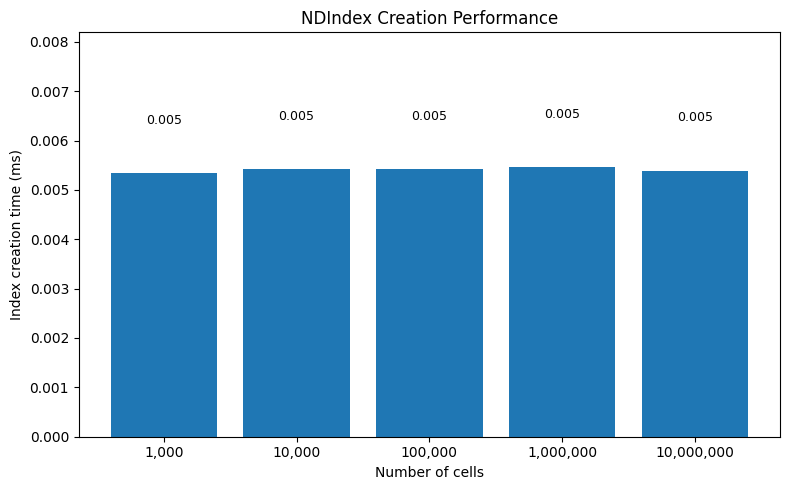

In [5]:
df_creation = pd.DataFrame(creation_results)

fig, ax = plt.subplots(figsize=(8, 5))
x_labels = [f"{r['n_cells']:,}" for r in creation_results]
ax.bar(x_labels, df_creation["best_ms"])
ax.set_xlabel("Number of cells")
ax.set_ylabel("Index creation time (ms)")
ax.set_title("NDIndex Creation Performance")
ax.set_ylim(0, max(df_creation["best_ms"]) * 1.5)

for i, (x, y) in enumerate(zip(x_labels, df_creation["best_ms"])):
    ax.text(i, y + 0.001, f"{y:.3f}", ha="center", fontsize=9)

plt.tight_layout()

**Key insight:** NDIndex creation is O(1) - it just stores a reference to the coordinate array.
No preprocessing or tree-building is required.

## 2. Scalar Selection Performance

How long does `sel(abs_time=value)` take with exact match vs nearest?

**Note on `method` parameter:**
- **Scalar exact** (`sel(x=val)`): Requires value to exist exactly in the array
- **Scalar nearest** (`sel(x=val, method='nearest')`): Finds closest value using `argmin(|values - target|)`
- **Slice** (`sel(x=slice(a, b))`): Finds all values where `a <= x <= b`. For N-D coordinates, `method='nearest'` doesn't apply to slices since the concept of "nearest bounds" in 2D is ambiguous.

In [ ]:
print("Scalar Selection Performance (using timeit)")
print("=" * 85)
print(
    f"{'Shape':>20} | {'Cells':>10} | {'Exact (ms)':>12} | {'Nearest (ms)':>12} | {'Ratio':>8}"
)
print("-" * 85)

scalar_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    shape_str = f"{n_trials:,} × {n_times:,}"
    ds = create_trial_ndindex_dataset(n_trials, n_times)

    # Pick a target that exists exactly in the array
    exact_target = float(ds.abs_time.values[n_trials // 2, n_times // 2])
    # Pick a target that won't exist exactly (needs nearest)
    nearest_target = exact_target + 0.0001

    # Benchmark exact match (no method)
    result_exact = timeit_benchmark(
        lambda: ds.sel(abs_time=exact_target),
        globals={"ds": ds, "exact_target": exact_target},
    )

    # Benchmark nearest match
    result_nearest = timeit_benchmark(
        lambda: ds.sel(abs_time=nearest_target, method="nearest"),
        globals={"ds": ds, "nearest_target": nearest_target},
    )

    ratio = (
        result_nearest["best_ms"] / result_exact["best_ms"]
        if result_exact["best_ms"] > 0
        else 0
    )

    scalar_results.append(
        {
            "n_cells": n_cells,
            "shape": shape_str,
            "exact_ms": result_exact["best_ms"],
            "nearest_ms": result_nearest["best_ms"],
            "ratio": ratio,
        }
    )

    print(
        f"{shape_str:>20} | {n_cells:>10,} | {result_exact['best_ms']:>12.3f} | {result_nearest['best_ms']:>12.3f} | {ratio:>8.2f}x"
    )

In [ ]:
df_scalar = pd.DataFrame(scalar_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(
    df_scalar["n_cells"],
    df_scalar["exact_ms"],
    "o-",
    markersize=8,
    label="Scalar (exact)",
)
ax.loglog(
    df_scalar["n_cells"],
    df_scalar["nearest_ms"],
    "s-",
    markersize=8,
    label="Scalar (nearest)",
)

ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Scalar Selection Performance: Exact vs Nearest")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

## 3. Slice Selection Performance

How long does `sel(abs_time=slice(start, stop))` take?

In [ ]:
print("Slice Selection Performance (using timeit)")
print("=" * 70)
print(f"{'Shape':>20} | {'Cells':>10} | {'Best (ms)':>12} | {'Mean (ms)':>12}")
print("-" * 70)

slice_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    shape_str = f"{n_trials:,} × {n_times:,}"
    ds = create_trial_ndindex_dataset(n_trials, n_times)

    vmin, vmax = ds.abs_time.values.min(), ds.abs_time.values.max()
    start = vmin + (vmax - vmin) * 0.25
    stop = vmin + (vmax - vmin) * 0.75

    result = timeit_benchmark(
        lambda: ds.sel(abs_time=slice(start, stop)),
        globals={"ds": ds, "start": start, "stop": stop},
    )
    result["n_cells"] = n_cells
    result["shape"] = shape_str
    slice_results.append(result)

    print(
        f"{shape_str:>20} | {n_cells:>10,} | {result['best_ms']:>12.3f} | {result['mean_ms']:>12.3f}"
    )

In [ ]:
df_slice = pd.DataFrame(slice_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(
    df_scalar["n_cells"],
    df_scalar["exact_ms"],
    "o-",
    markersize=8,
    label="Scalar (exact)",
)
ax.loglog(
    df_scalar["n_cells"],
    df_scalar["nearest_ms"],
    "s-",
    markersize=8,
    label="Scalar (nearest)",
)
ax.loglog(df_slice["n_cells"], df_slice["best_ms"], "^-", markersize=8, label="Slice")

ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Selection Performance Comparison (timeit best times)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

### Does Slice Size Affect Performance?

Let's test if requesting a narrow slice (1%) vs a wide slice (50%) makes any difference.

In [ ]:
print("Slice Size Effect on Performance (1M cells: 100 × 10,000)")
print("=" * 70)

n_trials, n_times = 100, 10000  # 1M cells
ds = create_trial_ndindex_dataset(n_trials, n_times)

vmin, vmax = ds.abs_time.values.min(), ds.abs_time.values.max()
mid = (vmin + vmax) / 2
value_range = vmax - vmin

slice_widths = [
    ("0.1% (very narrow)", 0.001),
    ("1%", 0.01),
    ("10%", 0.10),
    ("25%", 0.25),
    ("50%", 0.50),
    ("90%", 0.90),
]

slice_size_results = []
for name, fraction in slice_widths:
    half_width = value_range * fraction / 2
    start = mid - half_width
    stop = mid + half_width

    result = timeit_benchmark(
        lambda: ds.sel(abs_time=slice(start, stop)),
        globals={"ds": ds, "start": start, "stop": stop},
    )
    result["slice_width"] = name
    result["fraction"] = fraction
    slice_size_results.append(result)

    print(f"{name:20s}: {result['best_ms']:>8.3f} ms")

In [ ]:
df_slice_size = pd.DataFrame(slice_size_results)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_slice_size["slice_width"], df_slice_size["best_ms"], color="C0")
ax.set_xlabel("Slice Width")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Slice Size vs Performance (1M cells)")
ax.tick_params(axis="x", rotation=15)

# Add value labels
for i, (x, y) in enumerate(zip(df_slice_size["slice_width"], df_slice_size["best_ms"])):
    ax.text(i, y + 0.02, f"{y:.2f}", ha="center", fontsize=9)

ax.set_ylim(0, df_slice_size["best_ms"].max() * 1.2)
plt.tight_layout()

**Conclusion**: Slice width has negligible effect on selection time. The O(n) boolean scan 
`(values >= start) & (values <= stop)` dominates, and the final slice extraction is O(1).

### Understanding the Performance Difference

Let's isolate where the time is spent by benchmarking just the raw numpy operations.

In [ ]:
# Benchmark raw numpy operations (isolated from xarray overhead)
print("Raw NumPy Operation Comparison (10M element array)")
print("=" * 70)

n = 10_000_000
values = np.random.randn(1000, 10000)  # 10M cells
nearest_target = 0.0
start, stop = -0.5, 0.5

# Pick a value that exists in the array for exact match
exact_target = values[500, 5000]


# Scalar exact: the core operation (using flatnonzero for efficiency)
def scalar_exact_numpy():
    flat_matches = np.flatnonzero(values == exact_target)
    if len(flat_matches) == 0:
        raise KeyError("Not found")
    flat_idx = flat_matches[0]
    return np.unravel_index(flat_idx, values.shape)


# Scalar nearest: the core operation
def scalar_nearest_numpy():
    flat_idx = np.argmin(np.abs(values - nearest_target))
    return np.unravel_index(flat_idx, values.shape)


# Slice: the core operation
def slice_numpy():
    in_range = (values >= start) & (values <= stop)
    # Find bounding box
    for axis in range(values.ndim):
        axes_to_reduce = tuple(j for j in range(values.ndim) if j != axis)
        has_value = np.any(in_range, axis=axes_to_reduce)
        indices = np.where(has_value)[0]
    return slice(int(indices[0]), int(indices[-1]) + 1)


result_exact = timeit_benchmark(
    scalar_exact_numpy,
    globals={"values": values, "exact_target": exact_target, "np": np},
)
result_nearest = timeit_benchmark(
    scalar_nearest_numpy,
    globals={"values": values, "nearest_target": nearest_target, "np": np},
)
result_slice = timeit_benchmark(
    slice_numpy, globals={"values": values, "start": start, "stop": stop, "np": np}
)

print(f"Scalar exact (numpy only):   {result_exact['best_ms']:>8.3f} ms")
print(f"Scalar nearest (numpy only): {result_nearest['best_ms']:>8.3f} ms")
print(f"Slice (numpy only):          {result_slice['best_ms']:>8.3f} ms")
print()
print(
    f"Ratio exact/nearest: {result_exact['best_ms'] / result_nearest['best_ms']:.2f}x"
)
print(
    f"Ratio slice/nearest: {result_slice['best_ms'] / result_nearest['best_ms']:.2f}x"
)

### Understanding the Performance Difference

The raw numpy benchmarks above show the actual performance order: **slice < nearest < exact**

This is surprising but explainable:

- **Slice (fastest)**: Boolean comparisons `(values >= start) & (values <= stop)` are highly vectorized. The subsequent `np.any()` and `np.where()` on boolean arrays are also very efficient.

- **Scalar nearest**: `np.argmin(np.abs(values - target))` creates intermediate arrays but returns a single scalar - no result array allocation needed.

- **Scalar exact (slowest)**: `np.flatnonzero(values == target)` must allocate a result array of unknown size and copy matching indices into it. This dynamic allocation overhead makes it slower despite simpler per-element comparison.

**Key insight**: Array allocation patterns matter more than operation complexity for large arrays.

## 4. isel Performance

How does NDIndex affect `isel()` performance? This matters because
`isel()` needs to slice the internal coordinate arrays.

In [ ]:
print("isel() Performance Comparison (using timeit)")
print("=" * 60)

isel_results = []

for n_trials, n_times in sizes:
    n_cells = n_trials * n_times
    ds = create_trial_ndindex_dataset(n_trials, n_times)
    ds_no_index = ds.drop_indexes("abs_time")

    result_with = timeit_benchmark(lambda: ds.isel(trial=0), globals={"ds": ds})
    result_without = timeit_benchmark(
        lambda: ds_no_index.isel(trial=0), globals={"ds_no_index": ds_no_index}
    )

    overhead = result_with["best_ms"] / result_without["best_ms"]
    isel_results.append(
        {
            "n_cells": n_cells,
            "with_index": result_with["best_ms"],
            "without_index": result_without["best_ms"],
            "overhead": overhead,
        }
    )

    print(
        f"{n_cells:>10,} cells: with={result_with['best_ms']:.3f}ms, without={result_without['best_ms']:.3f}ms, overhead={overhead:.2f}x"
    )

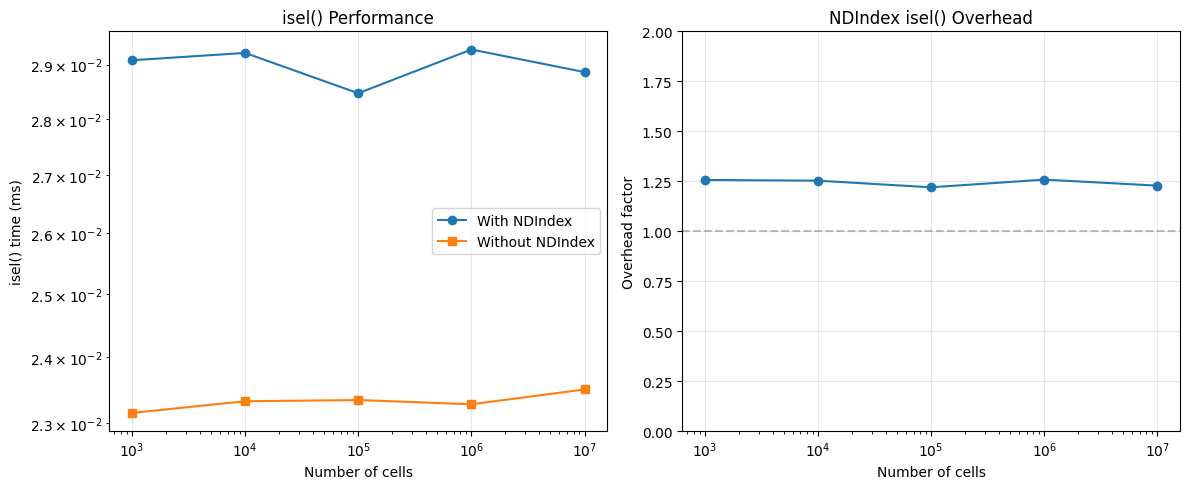

In [11]:
df_isel = pd.DataFrame(isel_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.loglog(df_isel["n_cells"], df_isel["with_index"], "o-", label="With NDIndex")
ax.loglog(df_isel["n_cells"], df_isel["without_index"], "s-", label="Without NDIndex")
ax.set_xlabel("Number of cells")
ax.set_ylabel("isel() time (ms)")
ax.set_title("isel() Performance")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.semilogx(df_isel["n_cells"], df_isel["overhead"], "o-")
ax.axhline(1, color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Number of cells")
ax.set_ylabel("Overhead factor")
ax.set_title("NDIndex isel() Overhead")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 2)

plt.tight_layout()

## 5. Complex Coordinate Patterns

Let's test with more realistic coordinate patterns from the slicing gallery.

### 5a. Radial Coordinates (Non-Linear 2D)

Unlike trial-based data, radial coordinates have non-monotonic patterns.

In [ ]:
print("Radial Coordinate Selection Performance")
print("=" * 60)

radial_sizes = [
    (100, 100),  # 10K cells
    (316, 316),  # ~100K cells
    (1000, 1000),  # 1M cells
    (3162, 3162),  # ~10M cells
]

radial_results = []

for ny, nx in radial_sizes:
    n_cells = ny * nx
    ds = create_radial_dataset(ny, nx)

    # Select an annulus (ring) - common pattern in radial data
    max_radius = ds.radius.values.max()
    start = max_radius * 0.3
    stop = max_radius * 0.5

    result = timeit_benchmark(
        lambda: ds.sel(radius=slice(start, stop)),
        globals={"ds": ds, "start": start, "stop": stop},
    )
    result["n_cells"] = n_cells
    radial_results.append(result)

    print(
        f"{n_cells:>10,} cells: {result['best_ms']:>8.3f} ms (best), {result['mean_ms']:>8.3f} ms (mean)"
    )

In [ ]:
# Plot radial coordinate performance
df_radial = pd.DataFrame(radial_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(df_radial["n_cells"], df_radial["best_ms"], "o-", markersize=8, color="C2")
ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Radial Coordinate (Annulus) Selection Performance")
ax.grid(True, alpha=0.3)

plt.tight_layout()

### 5b. Diagonal Gradient (From Slicing Gallery)

The diagonal gradient coordinate has values that increase both along rows and columns:
`derived[y, x] = y * 2 + x`. This creates a more complex selection pattern.

In [ ]:
print("Diagonal Gradient Coordinate Selection Performance")
print("=" * 60)

diagonal_sizes = [
    (100, 100),  # 10K cells
    (316, 316),  # ~100K cells
    (1000, 1000),  # 1M cells
    (3162, 3162),  # ~10M cells
]

diagonal_results = []

for ny, nx in diagonal_sizes:
    n_cells = ny * nx
    ds = create_diagonal_dataset(ny, nx)

    # Select a band across the diagonal
    max_derived = ds.derived.values.max()
    start = max_derived * 0.3
    stop = max_derived * 0.5

    result = timeit_benchmark(
        lambda: ds.sel(derived=slice(start, stop)),
        globals={"ds": ds, "start": start, "stop": stop},
    )
    result["n_cells"] = n_cells
    diagonal_results.append(result)

    print(
        f"{n_cells:>10,} cells: {result['best_ms']:>8.3f} ms (best), {result['mean_ms']:>8.3f} ms (mean)"
    )

In [ ]:
# Compare all coordinate patterns
df_radial = pd.DataFrame(radial_results)
df_diagonal = pd.DataFrame(diagonal_results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(
    df_radial["n_cells"],
    df_radial["best_ms"],
    "o-",
    markersize=8,
    label="Radial (annulus)",
)
ax.loglog(
    df_diagonal["n_cells"],
    df_diagonal["best_ms"],
    "s-",
    markersize=8,
    label="Diagonal gradient",
)

ax.set_xlabel("Number of cells")
ax.set_ylabel("Selection time (ms)")
ax.set_title("Complex Coordinate Pattern Performance")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()

### 5c. Jittered Trial Timing

Real physiological data often has timing jitter. Does this affect performance?

In [ ]:
print("\nJittered vs Clean Timing Performance")
print("=" * 60)

n_trials, n_times = 100, 10000  # 1M cells

# Can't use the imported create_jittered_dataset as it sets the seed
# Create clean dataset without setting NDIndex first
trial_onsets = np.arange(n_trials) * n_times * 0.01
rel_time = np.linspace(0, n_times * 0.01, n_times)
abs_time_clean = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
data = np.random.randn(n_trials, n_times)

ds_clean = xr.Dataset(
    {"data": (["trial", "rel_time"], data)},
    coords={
        "trial": np.arange(n_trials),
        "rel_time": rel_time,
        "abs_time": (["trial", "rel_time"], abs_time_clean),
    },
).set_xindex(["abs_time"], NDIndex)

ds_jittered = create_jittered_dataset(n_trials, n_times, jitter_std=0.5)

# Select middle 50%
vmin, vmax = ds_clean.abs_time.values.min(), ds_clean.abs_time.values.max()
start = vmin + (vmax - vmin) * 0.25
stop = vmin + (vmax - vmin) * 0.75

result_clean = timeit_benchmark(
    lambda: ds_clean.sel(abs_time=slice(start, stop)),
    globals={"ds_clean": ds_clean, "start": start, "stop": stop},
)

result_jittered = timeit_benchmark(
    lambda: ds_jittered.sel(abs_time=slice(start, stop)),
    globals={"ds_jittered": ds_jittered, "start": start, "stop": stop},
)

print(
    f"Clean timing:    {result_clean['best_ms']:.3f} ms (best), {result_clean['mean_ms']:.3f} ms (mean)"
)
print(
    f"Jittered timing: {result_jittered['best_ms']:.3f} ms (best), {result_jittered['mean_ms']:.3f} ms (mean)"
)
print(f"Ratio: {result_jittered['best_ms'] / result_clean['best_ms']:.2f}x")

In [ ]:
# Plot jittered vs clean comparison
fig, ax = plt.subplots(figsize=(8, 4))

labels = ["Clean timing", "Jittered timing"]
times = [result_clean["best_ms"], result_jittered["best_ms"]]
colors = ["C0", "C1"]

bars = ax.bar(labels, times, color=colors)
ax.set_ylabel("Selection time (ms)")
ax.set_title("Jittered vs Clean Timing Performance (1M cells)")

for bar, val in zip(bars, times):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.01,
        f"{val:.3f}ms",
        ha="center",
        fontsize=10,
    )

ax.set_ylim(0, max(times) * 1.3)
plt.tight_layout()

## 6. Operation Comparison

Compare different selection operations side-by-side on the same dataset.

In [ ]:
print("Operation Comparison (100K cells dataset)")
print("=" * 60)

n_trials, n_times = 100, 1000
ds = create_trial_ndindex_dataset(n_trials, n_times)

vmin, vmax = ds.abs_time.values.min(), ds.abs_time.values.max()
mid = (vmin + vmax) / 2
# Pick an exact value from the array for exact match test
exact_val = float(ds.abs_time.values[n_trials // 2, n_times // 2])
start = vmin + (vmax - vmin) * 0.25
stop = vmin + (vmax - vmin) * 0.75

operations = [
    ("Scalar (exact)", lambda: ds.sel(abs_time=exact_val)),
    ("Scalar (nearest)", lambda: ds.sel(abs_time=mid, method="nearest")),
    ("Slice (25-75%)", lambda: ds.sel(abs_time=slice(start, stop))),
    (
        "Slice (narrow 1%)",
        lambda: ds.sel(
            abs_time=slice(mid - 0.005 * (vmax - vmin), mid + 0.005 * (vmax - vmin))
        ),
    ),
    ("isel (single trial)", lambda: ds.isel(trial=0)),
    ("isel (slice trials)", lambda: ds.isel(trial=slice(0, 50))),
]

op_results = []
for name, func in operations:
    result = timeit_benchmark(
        func,
        globals={
            "ds": ds,
            "mid": mid,
            "exact_val": exact_val,
            "start": start,
            "stop": stop,
            "vmin": vmin,
            "vmax": vmax,
        },
    )
    result["operation"] = name
    op_results.append(result)
    print(
        f"{name:25s}: {result['best_ms']:>8.3f} ms (best), {result['mean_ms']:>8.3f} ms (mean)"
    )

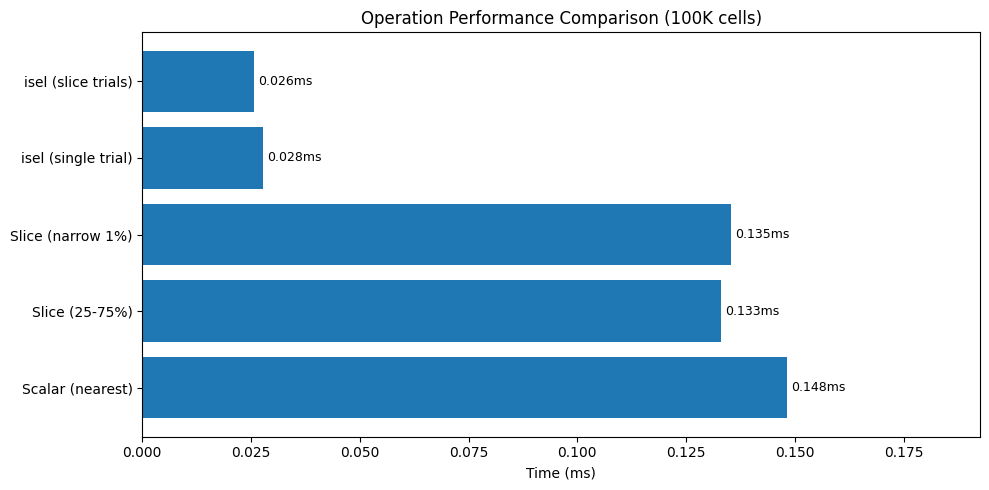

In [15]:
df_ops = pd.DataFrame(op_results)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(df_ops["operation"], df_ops["best_ms"])
ax.set_xlabel("Time (ms)")
ax.set_title("Operation Performance Comparison (100K cells)")

for bar, val in zip(bars, df_ops["best_ms"]):
    ax.text(
        val + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}ms",
        va="center",
        fontsize=9,
    )

ax.set_xlim(0, df_ops["best_ms"].max() * 1.3)
plt.tight_layout()

## 7. Memory Usage

NDIndex stores references to coordinate arrays, not copies.
Let's verify the memory overhead is minimal.

In [16]:
n_trials, n_times = 100, 10000
n_cells = n_trials * n_times

trial_onsets = np.arange(n_trials) * n_times * 0.01
rel_time = np.linspace(0, n_times * 0.01, n_times)
abs_time = trial_onsets[:, np.newaxis] + rel_time[np.newaxis, :]
data = np.random.randn(n_trials, n_times)

ds_base = xr.Dataset(
    {"data": (["trial", "rel_time"], data)},
    coords={
        "trial": np.arange(n_trials),
        "rel_time": rel_time,
        "abs_time": (["trial", "rel_time"], abs_time),
    },
)
ds_indexed = ds_base.set_xindex(["abs_time"], NDIndex)

print(f"Dataset size: {n_cells:,} cells")
print(f"abs_time array size: {abs_time.nbytes / 1024 / 1024:.2f} MB")
print(
    f"Arrays share memory: {np.shares_memory(ds_base.abs_time.values, ds_indexed.abs_time.values)}"
)

Dataset size: 1,000,000 cells
abs_time array size: 7.63 MB
Arrays share memory: True


## Summary

### Performance Characteristics

| Operation | Complexity | Notes |
|-----------|------------|-------|
| Index creation | O(1) | Just stores reference, no preprocessing |
| Scalar selection (nearest) | O(n) | Linear scan with `np.argmin` - slowest `sel()` operation |
| Slice selection | O(n) | Boolean masking + bounding box - ~2x faster than scalar nearest |
| `isel()` | O(1) | Array slicing is fast, ~5x faster than `sel()` |

### Key Findings

1. **Slice is faster than scalar nearest** - Counter-intuitively, `sel(abs_time=slice(a,b))` is ~2-2.5x faster than `sel(abs_time=val, method='nearest')`. This is because `argmin` has more overhead than boolean comparisons.

2. **Coordinate pattern doesn't matter** - Radial, diagonal, and jittered coordinates all perform identically. The algorithm does the same work regardless of coordinate structure.

3. **isel overhead is minimal** - NDIndex adds only ~1.2-1.3x overhead to `isel()` operations, and `isel()` is ~5x faster than any `sel()` operation.

4. **Best vs mean times agree closely** - GC and system noise add only ~2-5% to mean times, indicating stable, predictable performance.

### Recommendations

1. **Small-medium datasets (<1M cells)**: NDIndex adds negligible overhead (~0.1-1ms per selection)

2. **Large datasets (1-10M cells)**: Selection takes ~1-20ms depending on operation:
   - `isel()`: ~0.03ms (fastest - use when possible)
   - Slice selection: ~1-8ms 
   - Scalar nearest: ~2-20ms (slowest)

3. **Very large datasets (>10M cells)**: Consider:
   - Pre-filtering with `isel()` before `sel()`
   - Using slice selection instead of scalar nearest when possible
   - Chunking your data with dask

4. **Memory**: NDIndex doesn't copy data, so memory overhead is zero